# Test Different Weight and Bias Values on Fashion MNIST Dataset

Load imports. Make sure that onnx is imported before Torch. __ONNX is always imported before Torch__

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

## Load The Fashion MNIST Dataset Using PyTorch

Here we load the Fashion MNIST dataset using `torchvision.datasets.FashionMNIST`, and specify that we want to download the dataset if it isn't already downloaded. We also use the transform argument to apply the `transforms.Compose([transforms.ToTensor()])` transformation to each image, which converts the images from PIL Images to PyTorch Tensors.

We then wrap the `train_set` and `test_set` datasets in PyTorch `DataLoader` objects, which allow us to load the data in batches for more efficient processing during training and testing.

Finally, we use `next(iter(train_loader))` to retrieve the first batch of training data from the `train_loader`, and print the size of the batch and the total number of training examples in train_set.

In [19]:
# Load Fashion MNIST dataset
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

# Loaders
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=1000)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1000)

a = next(iter(train_loader))
print(a[0].size())
print(len(train_set))

torch.Size([1000, 1, 28, 28])
60000


9


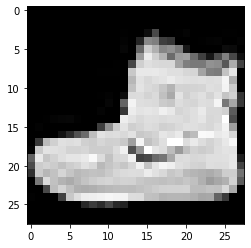

In [20]:
image, label = next(iter(train_set))

plt.imshow(image.squeeze(), cmap="gray")
print(label)

## Data Loader

Using PyTorch dataloader we can create a convenient iterator over the dataset that returns batches of data, rather than requiring manual batch creation. 

In [22]:
# set batch size
batch_size = 1000

# Create a DataLoader for a training dataset with a batch size of 100
train_quantized_loader = DataLoader(train_set, batch_size=batch_size)
test_quantized_loader = DataLoader(test_set, batch_size=batch_size)

# Get the first batch from the demo_loader
batch = next(iter(demo_loader))

# Split the batch into images and labels tensors
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1000, 1, 28, 28]) torch.Size([1000])
